# Advanced Topics -- Custom Kernels

(Boiled down from: https://docs.oceanparcels.org/en/v3.0.4/examples/parcels_tutorial.html)

## Basic setup

In [1]:
from pathlib import Path
example_data_path = Path("../../parcels_example_data/")

## Importing relevant modules

We need to import `parcels` itself along with `matplotlib`, `xarray`, and `datetime`.

In [2]:
import parcels

from matplotlib import pyplot as plt
import cartopy

import xarray as xr
import numpy as np
import math

import datetime

## Create FieldSet

Load the example data from the `"GlobCurrent_example_data"` directory.
Filesnames are starting with a year in the 2000's.


Hints:
- use the `.from_netcdf()` method to create the fieldset
- variable `"eastward_eulerian_current_velocity"` is `"U"`
- variable `"northward_eulerian_current_velocity"` is `"V"`.
- dimensions are `"time"`, `"lon"`, `"lat"`.

In [3]:
GlobCurrent_example_data_path = example_data_path / "GlobCurrent_example_data"

In [4]:
filenames = {
    "U": GlobCurrent_example_data_path / "20*.nc",
    "V": GlobCurrent_example_data_path / "20*.nc",
}

In [5]:
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}

In [6]:
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions, deferred_load=False)

## Create ParticleSet

Now define a `ParticleSet`, in this case with 2_000 particle starting randomly distributed within the bounds of the fieldset. Use the `ParticleSet.from_list` constructor method again.

In [7]:
number_particles = 1_000
lon_bds = (24, 27)
lat_bds = (-39, -34.5)
time_0 = fieldset.U.grid.time[0]

In [8]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=parcels.JITParticle,
    lon=np.random.uniform(*lon_bds, size=(number_particles, )),
    lat=np.random.uniform(*lat_bds, size=(number_particles, )),
    time=time_0 + np.zeros(shape=(number_particles, ))
)

## Error kernel

Particles will leave the regional domain covered by the velocity data we provide here. This will lead to an `ErrorOutOfBounds` status of the particle. We'll handle this by capturing all status codes which indicate errors and deleting the respective article.

(See https://docs.oceanparcels.org/en/latest/examples/tutorial_kernelloop.html#Working-with-Status-Codes) 

In [9]:
def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

## Create a custom kernel

Let's add some eastward drift. Note that we need to provide the drift velocity in degrees per second.

In [10]:
def EastwardDrift(particle, fieldset, time):
    u_drift_mps = 1.5
    u_drift_degps = u_drift_mps / 111e3 / math.cos(math.pi / 180.0 * particle.lat)
    particle_dlon += u_drift_degps * particle.dt

Execute the `ParticleSet` for 10 days at 5-minute time step using the 4th order Runge-Kutta kernel, with the drift kernel, and the error kernel above.
Capture output every 6 hours.

## Execute

In [11]:
output_file = pset.ParticleFile(
    name="GlobCurrentParticles_eastward_drift.zarr",
    outputdt=datetime.timedelta(hours=1),
)
pset.execute(
    [parcels.AdvectionRK4, EastwardDrift, CheckError],
    runtime=datetime.timedelta(days=10),
    dt=datetime.timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in GlobCurrentParticles_eastward_drift.zarr.
100%|████████████████████████████████████████████████████████████████████████████| 864000.0/864000.0 [00:32<00:00, 26484.20it/s]


## Have a look at the output

In [12]:
ds = xr.open_zarr("GlobCurrentParticles_eastward_drift.zarr").compute()
ds

<xarray.Dataset> Size: 5MB
Dimensions:     (trajectory: 1000, obs: 241)
Coordinates:
  * obs         (obs) int32 964B 0 1 2 3 4 5 6 7 ... 234 235 236 237 238 239 240
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    lat         (trajectory, obs) float32 964kB -38.24 -38.21 -38.18 ... nan nan
    lon         (trajectory, obs) float32 964kB 24.02 24.12 24.22 ... nan nan
    time        (trajectory, obs) datetime64[ns] 2MB 2002-01-01 ... NaT
    z           (trajectory, obs) float32 964kB 0.0 0.0 0.0 0.0 ... nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4EastwardDriftCheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.4

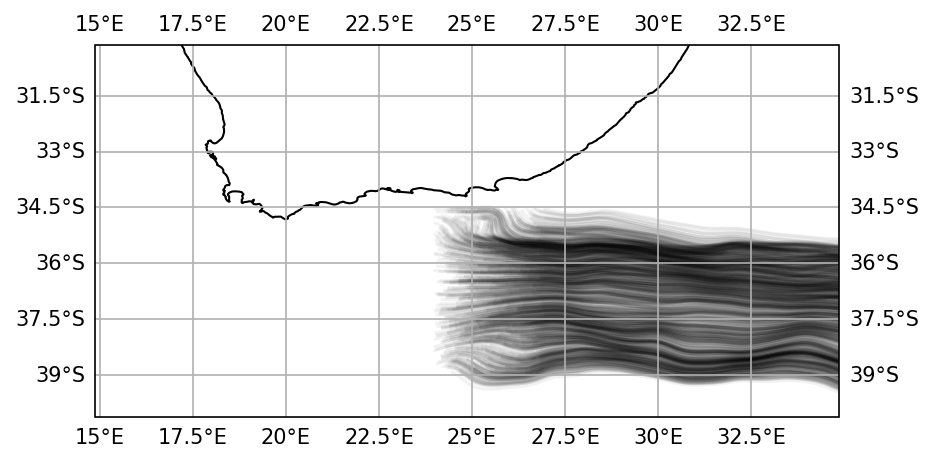

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": cartopy.crs.PlateCarree()})
fig.set_dpi(150)
for n in range(ds.sizes["trajectory"]):
    ax.plot(
        *ds.isel(trajectory=n)[["lon", "lat"]].dropna("obs").data_vars.values(),
        color="k", alpha=0.05,
        transform=cartopy.crs.PlateCarree(),
    )
ax.coastlines()
ax.set_extent([
    np.min(fieldset.U.grid.lon),
    np.max(fieldset.U.grid.lon),
    np.min(fieldset.U.grid.lat),
    np.max(fieldset.U.grid.lat),
])
ax.gridlines(draw_labels=True);